## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [11]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y      

In [13]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=False):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())

    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [14]:
"""
訓練模型
"""
def complie_train_model(model, optimizer, epochs, batch_size, callbacks, x_train, y_train, x_test, y_test, loss="categorical_crossentropy"):
    model.compile(loss=loss, metrics=["accuracy"], optimizer= optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          callbacks=callbacks, 
          shuffle=True)
    return model

In [15]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results, title=""):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)  

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    g1.set_title(title) 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    g2.set_title(title) 
    return df_acc_results, df_loss_results, g1, g2

In [16]:
"""
設定 callbacks
"""

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def setup_callbacks(ismodelckpt=False, isearlystop=False, isreducelr = False, 
                    monitor="val_acc", save_only="best", patience=5, min_lr= 1e-12, factor=0.5 ):
    cbs=list()
    
    if ismodelckpt:
        modelckpt = ModelCheckpoint(filepath="./tmp.h5",
                                    monitor=monitor, 
                                    save_best_only="best" in save_only,
                                    save_weights_only="weights" in save_only)
        cbs.append(modelckpt)
    if isearlystop:
        earlystop = EarlyStopping(monitor=monitor, 
                                  patience=patience, 
                                  verbose=1)
        cbs.append(earlystop)
    if isreducelr:
        reducelr = ReduceLROnPlateau(factor=factor, 
                              min_lr=min_lr, 
                              monitor=monitor, 
                              patience=patience, 
                              verbose=1)
        cbs.append(reducelr)
    return cbs

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [58]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weight=0.2):
    """Define the customized loss."""

    gamma = float(gamma)
    alpha = float(alpha)
    print("**********ce_weight {}******************".format(ce_weight))
    
    def combined_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        reduced_mean_fl = tf.reduce_mean(reduced_fl)    
        
        reduced_ce = tf.reduce_max(ce, axis=1)
        reduced_mean_ce = tf.reduce_mean(reduced_ce)
        
        # return ce_weight * reduced_mean_ce + (1-ce_weight) * reduced_mean_fl
        return tf.add(tf.multiply(ce_weight,reduced_mean_ce), tf.multiply((1-ce_weight), reduced_mean_fl))
    
    return combined_loss_fixed    
    


In [65]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
L2_EXP = 1e-3

ce_weights_list = [0., 0.3, 0.5, 0.7, 1.0]

In [66]:
"""
撰寫你的訓練流程並將結果用 results 紀錄
"""
results = list()

for i, ce_weight in enumerate(ce_weights_list):
    print("Numbers of exp:{},ce_weight:{:.2f}".format(i, ce_weight))
    keras.backend.clear_session() # 把舊的 Graph 清掉
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=regularizer, dropout_ratio=DROPOUT_EXP, isBN=True)
    optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    callbacks = setup_callbacks(ismodelckpt=True)
    model = complie_train_model(model=model,optimizer=optimizer, epochs=EPOCHS , batch_size=BATCH_SIZE, callbacks=callbacks, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,  loss= combined_loss(ce_weight=ce_weight))
    results.append({"tag": "ce_w={:.2f}".format(ce_weight), "model":model})
    

Numbers of exp:0,ce_weight:0.00
**********ce_weight 0.0******************
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 338us/step - loss: 40.7406 - acc: 0.2691 - val_loss: 39.2892 - val_acc: 0.3635A: 56s - loss: 42.5936 - acc: 0.123 - ETA: 40s - loss: 42.5076 - acc - ETA: 19s - loss: 41.9813 - acc: 0.1 - ETA: 15s - loss: 41.8220 - acc: 0.191 - ETA: 14s - ETA: 4s - loss: 41.0900 - acc:  - ETA: 2s - loss: 40.9953 - acc: 0.25 - ETA: 2s - loss: 40.9628 - acc:  - ETA: 1s - loss: 40.8769 - a
Epoch 2/25
50000/50000 [==============================] - 10s 210us/step - loss: 38.6975 - acc: 0.3776 - val_loss: 37.8931 - val_acc: 0.4087- - ETA - ETA: 1s - loss: 38.7829
Epoch 3/25
50000/50000 [==============================] - 11s 211us/step - loss: 37.4100 - acc: 0.4141 - val_loss: 36.7551 - val_acc: 0.4282s - loss: 37.8878 - a - ETA: 7s - loss: 37.8175 - acc: 0.40 - ETA: 7s - loss: 37.8017 - a - ETA: 6s - loss: 37. - ETA: 4s - los 

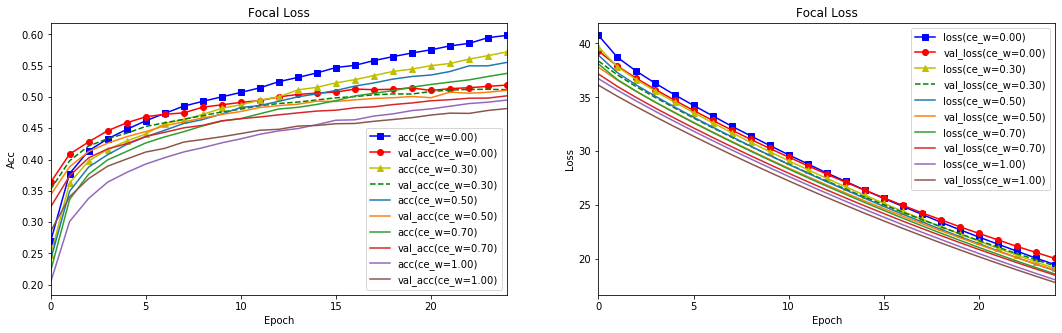

In [67]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results, g1, g2 = show_train_history(results, "Focal Loss")

In [76]:
df_acc_results.apply(lambda x: max(x)).sort_values(ascending=False)

acc(ce_w=0.00)        0.59852
acc(ce_w=0.30)        0.57206
acc(ce_w=0.50)        0.55536
acc(ce_w=0.70)        0.53780
val_acc(ce_w=0.00)    0.51910
val_acc(ce_w=0.30)    0.51230
val_acc(ce_w=0.50)    0.51070
val_acc(ce_w=0.70)    0.50190
acc(ce_w=1.00)        0.49524
val_acc(ce_w=1.00)    0.48160
dtype: float64

In [78]:
df_loss_results.apply(lambda x: max(x)).sort_values(ascending=True)

val_loss(ce_w=1.00)    36.125881
loss(ce_w=1.00)        36.724476
val_loss(ce_w=0.70)    37.156617
val_loss(ce_w=0.50)    37.788694
loss(ce_w=0.70)        38.094535
val_loss(ce_w=0.30)    38.362817
loss(ce_w=0.50)        38.906288
val_loss(ce_w=0.00)    39.289187
loss(ce_w=0.30)        39.639588
loss(ce_w=0.00)        40.740612
dtype: float64